In [1]:
import numpy as np
import pandas as pd
import time
import tqdm.notebook
import tqdm
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from matplotlib import pyplot as plt
import math
# import librosa
# import librosa.display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
col_names = ['time', 'emg_1', 'emg_2', 'emg_3', 'emg_4', 'emg_5', 'emg_6', 'emg_7', 'pred_pot', 'pot']
data = pd.read_csv('/content/drive/MyDrive/ЭМГ/german2.csv', sep=';', header=None, names=col_names)
# data2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv', sep=';', header=None, names=col_names)

In [5]:
# data = data[:26000]
data

,time,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,pred_pot,pot
0,0.002,638.397655,0,0,1650.806058,1650.806058,1444.455300,1444.4553,0,174
1,0.004,1650.806058,0,0,1650.806058,1650.806058,1444.455300,1444.4553,0,332
2,0.006,1650.806058,0,0,1650.806058,1650.806058,1444.455300,1444.4553,0,473
3,0.008,1650.806058,0,0,1650.806058,1444.455300,1444.455300,1444.4553,0,601
4,0.010,1444.455300,0,0,1650.806058,1650.806058,1444.455300,1444.4553,0,716
...,...,...,...,...,...,...,...,...,...,...
44689,89.380,1444.455300,0,0,1444.455300,1444.455300,1650.806058,1444.4553,0,1769
44690,89.382,1444.455300,0,0,1444.455300,1444.455300,1650.806058,1444.4553,0,1769
44691,89.384,1444.455300,0,0,1444.455300,1444.455300,1650.806058,1444.4553,0,1770
44692,89.386,1444.455300,0,0,1444.455300,1444.455300,1650.806058,1444.4553,0,1771


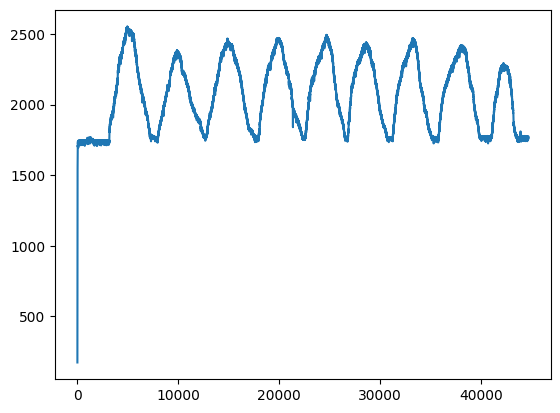

In [6]:
data['pot'].plot()
# plt.xlim((1000, 1500))
# plt.ylim((-2.5, 2.5))
Test = np.array([])
for i in data['pot']:
  np.append(Test, i)

In [7]:
data[['pot']] = data[['pot']].astype(float)
data.dtypes

time        float64
emg_1       float64
emg_2         int64
emg_3         int64
emg_4       float64
emg_5       float64
emg_6       float64
emg_7       float64
pred_pot      int64
pot         float64
dtype: object

<Axes: >

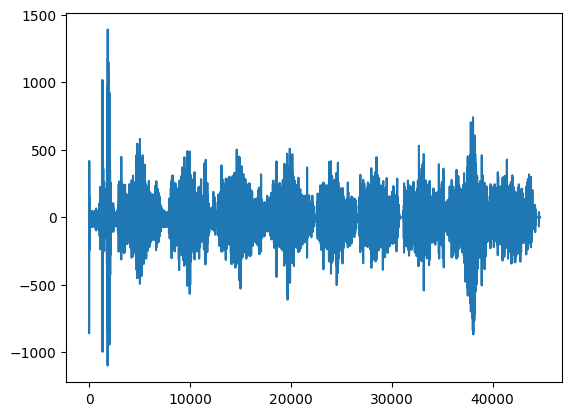

In [9]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

fs = 500.0
lowcut = 15.0
highcut = 100.0
data['emg_1'] = butter_bandpass_filter(data['emg_1'], lowcut, highcut, fs, order=6)
data['emg_4'] = butter_bandpass_filter(data['emg_4'], lowcut, highcut, fs, order=6)
data['emg_5'] = butter_bandpass_filter(data['emg_5'], lowcut, highcut, fs, order=6)
data['emg_6'] = butter_bandpass_filter(data['emg_6'], lowcut, highcut, fs, order=6)
data['emg_7'] = butter_bandpass_filter(data['emg_7'], lowcut, highcut, fs, order=6)
data['emg_1'].plot()

<Axes: >

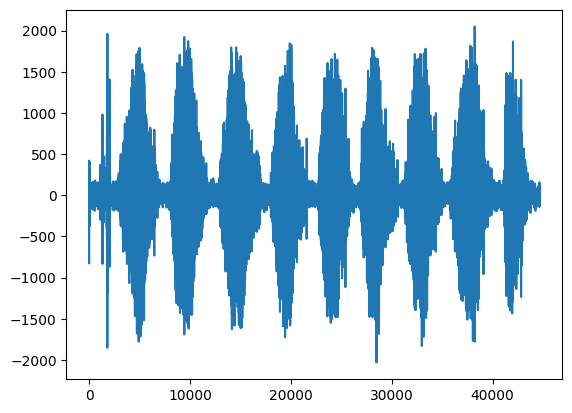

In [10]:
data['emg_4'].plot()

In [11]:
Mean = data.mean()
Var = data.std()
Mean2 = data.mean()
Var2 = data.std()

In [12]:
data = (data - data.mean()) / data.std()

Text(0.5, 0, 'Timestamps (1 ts = 2 ms)')

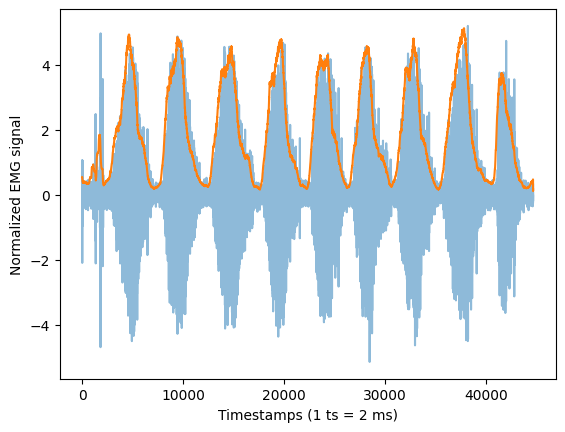

In [13]:
#smoothing

def emg_envelope(signal, window):
    env = []
    for i in range(0, len(signal)):
        env.append(np.mean(signal[i:i+window]))
    return np.array(env)

window = 400
data['emg_4_env'] = emg_envelope(np.abs(data['emg_4']), window)

plt.plot(data['emg_4'], alpha=0.5)
plt.plot(np.array(range(len(data['emg_4']))), 3*data['emg_4_env'])
plt.ylabel('Normalized EMG signal')
plt.xlabel('Timestamps (1 ts = 2 ms)')

In [14]:
from numpy.core.fromnumeric import size
x_size = 100
y_size = 50
Batch_size = 100

def create_sequences(values, x_size, y_size):
    X_output = []
    Y_output = []
    for i in range(0, len(values)-y_size - x_size-1, x_size):
        X_output.append(values[i : (i + x_size)])
        Y_output.append(values[(i + x_size) : (i + x_size + y_size)])
    print(np.shape(X_output))
    print(np.shape(Y_output))
    return torch.FloatTensor(X_output).permute(0, 2, 1), torch.FloatTensor(Y_output).permute(0, 2, 1)
    # return torch.from_numpy(X_output).to(torch.float32).permute(0, 2, 1), torch.from_numpy(Y_output).to(torch.float32).permute(0, 2, 1)


X, Y = create_sequences(data.values, x_size, y_size)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, shuffle=False)
print("Training x input shape: ", x_train.shape)
print("Training y input shape: ", y_train.shape)
train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=False)

(446, 100, 11)
(446, 50, 11)
Training x input shape:  torch.Size([401, 11, 100])
Training y input shape:  torch.Size([401, 11, 50])


<ipython-input-14-f83aab23ab26>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.FloatTensor(X_output).permute(0, 2, 1), torch.FloatTensor(Y_output).permute(0, 2, 1)


In [16]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_features=x_size, out_features=30),
            nn.ReLU(),
            nn.Linear(in_features=30, out_features=16),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=16, out_features=30),
            nn.ReLU(),
            nn.Linear(in_features=30, out_features=x_size)
        )
    def forward(self, sample):
        latent = self.encoder(sample)
        res = self.decoder(latent)
        return res

In [17]:
n_epochs = 50
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = Autoencoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.007)
loss_fn = F.mse_loss
train_losses = []
val_losses = []
for epoch in tqdm.notebook.tqdm(range(n_epochs)):
    model.train()
    train_losses_per_epoch = []
    k = 0
    for X_batch, Y_batch in train_loader:
        YB = X_batch[:,10] #  Y_batch torch.Size([100, 3, 50])
        optimizer.zero_grad()
        # print(X_batch.shape)
        # print(X_batch[:, 2, :].shape)
        reconstructed =model(X_batch[:, 10, :].to(device)) #torch.unsqueeze( # берем все элементы батча, начиная со второго канала, по всем его точкам torch.Size([100, 50])
        # plt.plot(x[:50], YB[0])
        # plt.plot(x[25:75], YB[1])
        # print(Y_batch.shape, YB[0:2].shape, reconstructed.shape)
        # plt.plot(reconstructed[:, 0].cpu().detach().numpy(), label = 'pred')
        # plt.legend()
        # break
        loss = loss_fn(reconstructed, YB.to(device))### .to(device)

        loss.backward()
        optimizer.step()
        train_losses_per_epoch.append(loss.item())
    train_losses.append(np.mean(train_losses_per_epoch))

    # break
    model.eval()
    val_losses_per_epoch = []
    with torch.no_grad():
        for X_batch, Y_batch in val_loader:
            YB = X_batch[:, 10]
            reconstructed = model(X_batch[:, 10, :].to(device)) #model(X_batch.to(device)) or [:, 2:, :]
            loss = loss_fn(reconstructed, YB.to(device))####
            val_losses_per_epoch.append(loss.item())

    val_losses.append(np.mean(val_losses_per_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

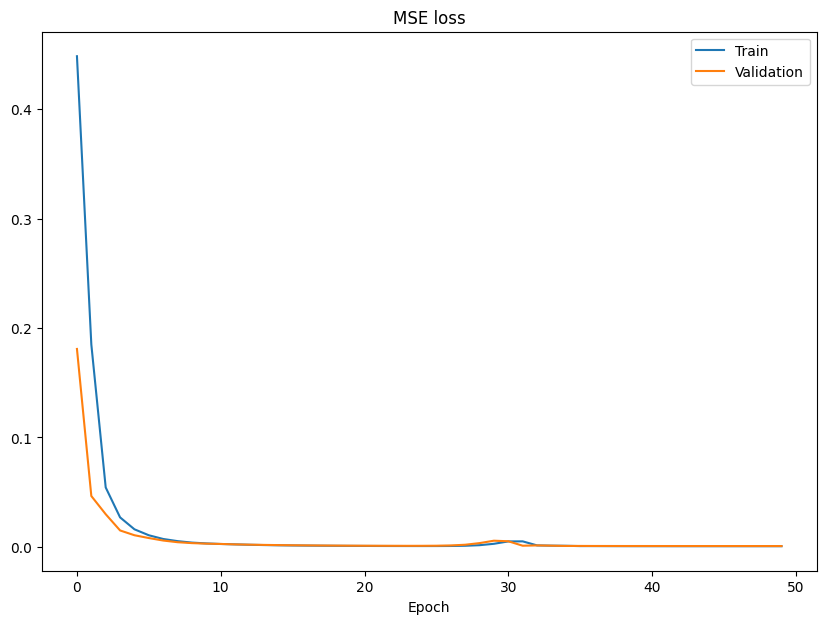

In [18]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(val_losses)), val_losses, label='Validation')

plt.xlabel('Epoch')
plt.title('MSE loss')
plt.legend()
plt.show()

In [93]:
def get_difference_score(preds, x, threshold=0.1):
    print(torch.max(preds - x))
    if torch.max(torch.abs(preds - x)) > threshold:
        return f'ANOMALY: {torch.max(torch.abs(preds - x))}' 
    else:
        return f'NO: {torch.max(torch.abs(preds - x))}'

You can change threshold in get_difference_score function.

1
tensor(0.1527)
ANOMALY!


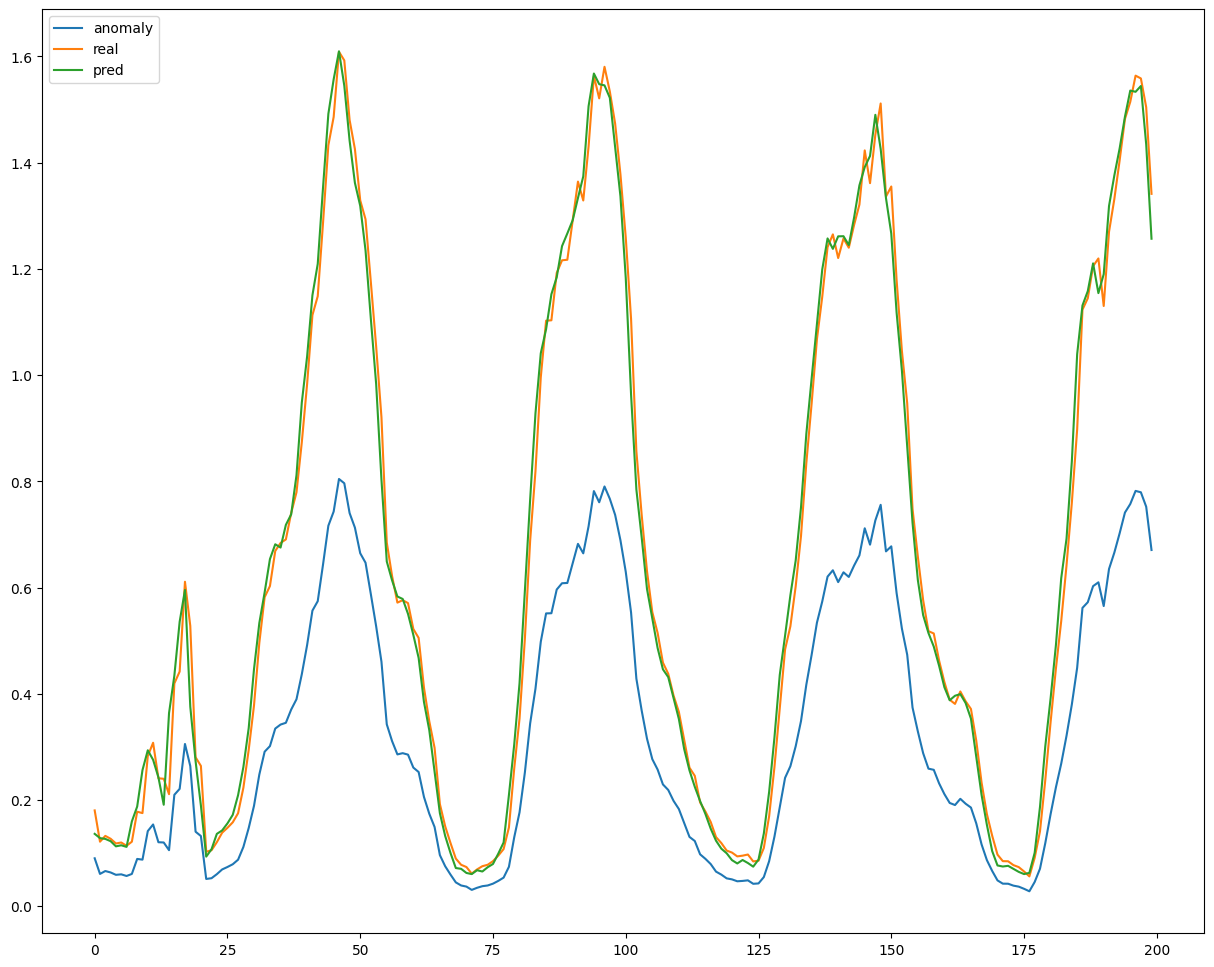

In [52]:
test_loader = DataLoader(train_dataset, batch_size=200, shuffle=False)

model.eval()
x_pred = []
ground = []
losses = []
plt.figure(figsize=(15, 12))
metric = []
i = 0
with torch.no_grad():
    for x_batch, y_batch in test_loader: # x_batch.shape torch.Size([100, 3, 25])
        # if i != 1:

        #     pred = model(x_batch[:, 10, :].to(device)).cpu().numpy()
        #     ground.append(x_batch[:, 10, 0])
        # else:
        #     pred = model(0.5 * x_batch[:, 10, :].to(device)).cpu().numpy()
        #     ground.append(0.5*x_batch[:, 10, 0])
        #     plt.plot(x_batch[:, 10, 0], label='Ground truth')
        #     plt.plot(pred[:, 0], label='Predicted')
        #     plt.legend()

        # i += 1

        # x_pred.append(pred[:, 0]) # final size = [56; 100]

        # ground.append(y_batch[:, 10, 0])      
        # losses.append(np.mean(np.abs(pred - y_batch[:, 10, :50].numpy())))
        # metric.append(pred - y_batch[:, 10, :25].numpy())
        print(1)
        plt.plot(0.5 * x_batch[:, 10, 0], label='anomaly')
        plt.plot(x_batch[:, 10, 0], label='real')
        pred = model(x_batch[:, 10, :].to(device))
        plt.plot(pred[:, 0], label='pred')
        # get_difference_score()
        plt.legend()
        get_difference_score(pred[:, 0], x_batch[:, 10, 0].to(device))
        break

tensor(0.1521)
tensor(0.0746)
tensor(0.1175)
tensor(0.0456)
tensor(0.0447)
tensor(0.1426)
tensor(0.0273)
tensor(0.0888)
tensor(0.0311)
tensor(0.0845)


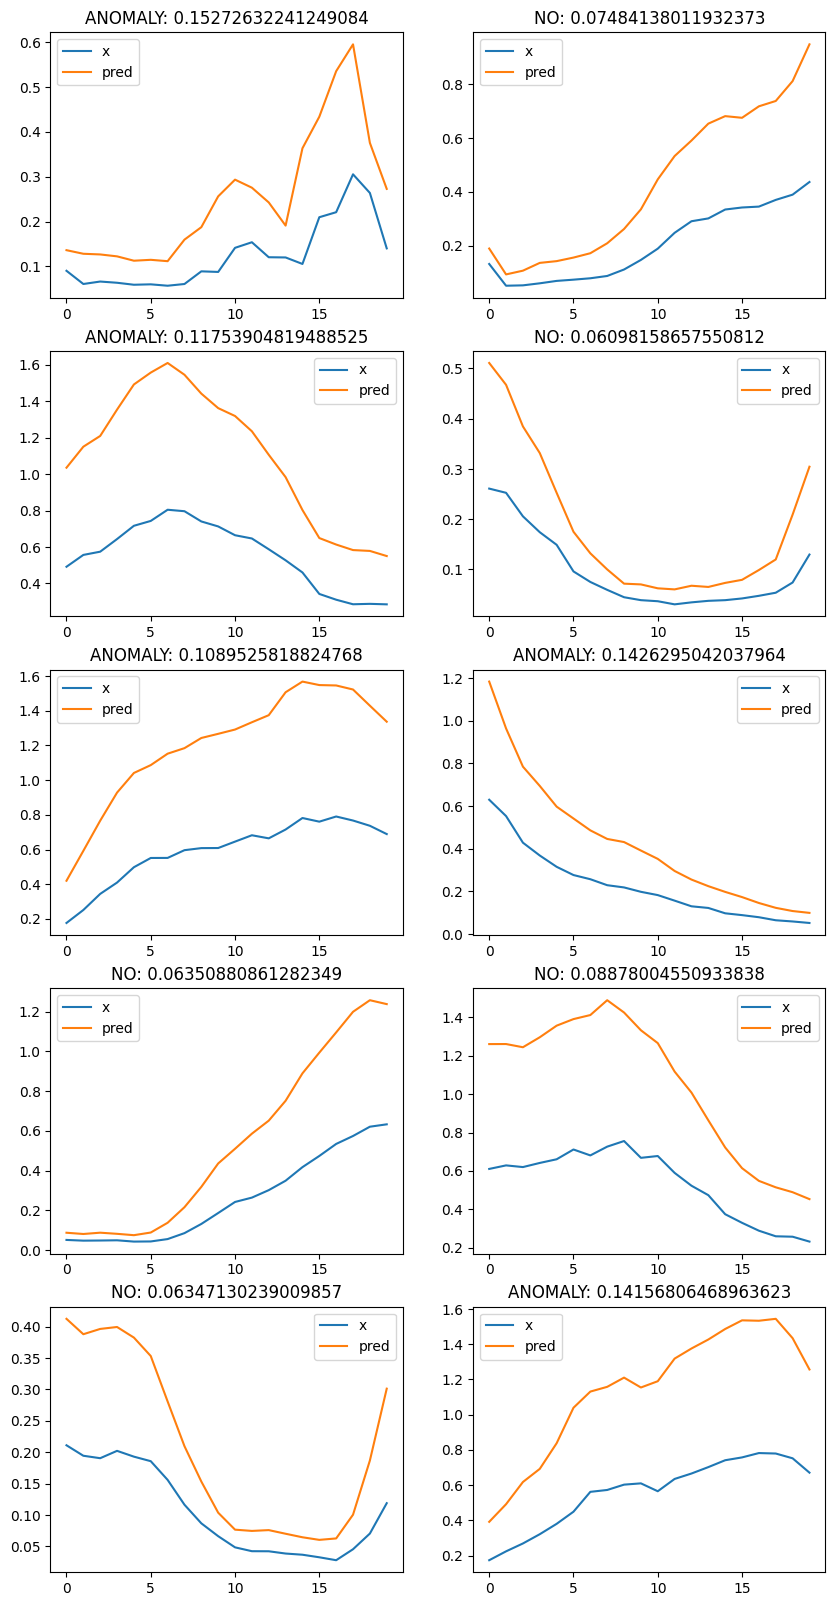

In [94]:
x_ = x_batch[:, 10, 0]
pred_ =  pred[:, 0]
fig, axs = plt.subplots(5, 2, figsize=(10, 20))
k = 0
for i in range(0, 200, 20): # 0, 20, 40, 60, ... -> 0, 1, 2, 3, ...
    j = i // 20
    # k = 0
    if j % 2 == 0: 
        axs[k][j % 2].set_title(f'{get_difference_score(x_[i: i+20], pred_[i: i+20])}')
        axs[k][j % 2].plot(0.5*x_[i: i+20], label='x')
        axs[k][j % 2].plot(pred_[i: i+20], label='pred')
        axs[k][j % 2].legend()
    else:
        axs[k][j % 2].set_title(f'{get_difference_score(x_[i: i+20], pred_[i: i+20])}')
        axs[k][j % 2].plot(0.5*x_[i: i+20], label='x')
        axs[k][j % 2].plot(pred_[i: i+20], label='pred')
        axs[k][j % 2].legend()
        k += 1

In [22]:
gr = []
predict = []
for j in range(len(ground)):
    for i in range(len(ground[j])):
        a = ground[j][i] # 5 - любое число, ставится от балды
        b = x_pred[j][i]
        gr.append(a)
        predict.append(b)
np.shape(gr)
gr = torch.ravel(torch.stack(gr))
pred = np.ravel(np.stack(predict))

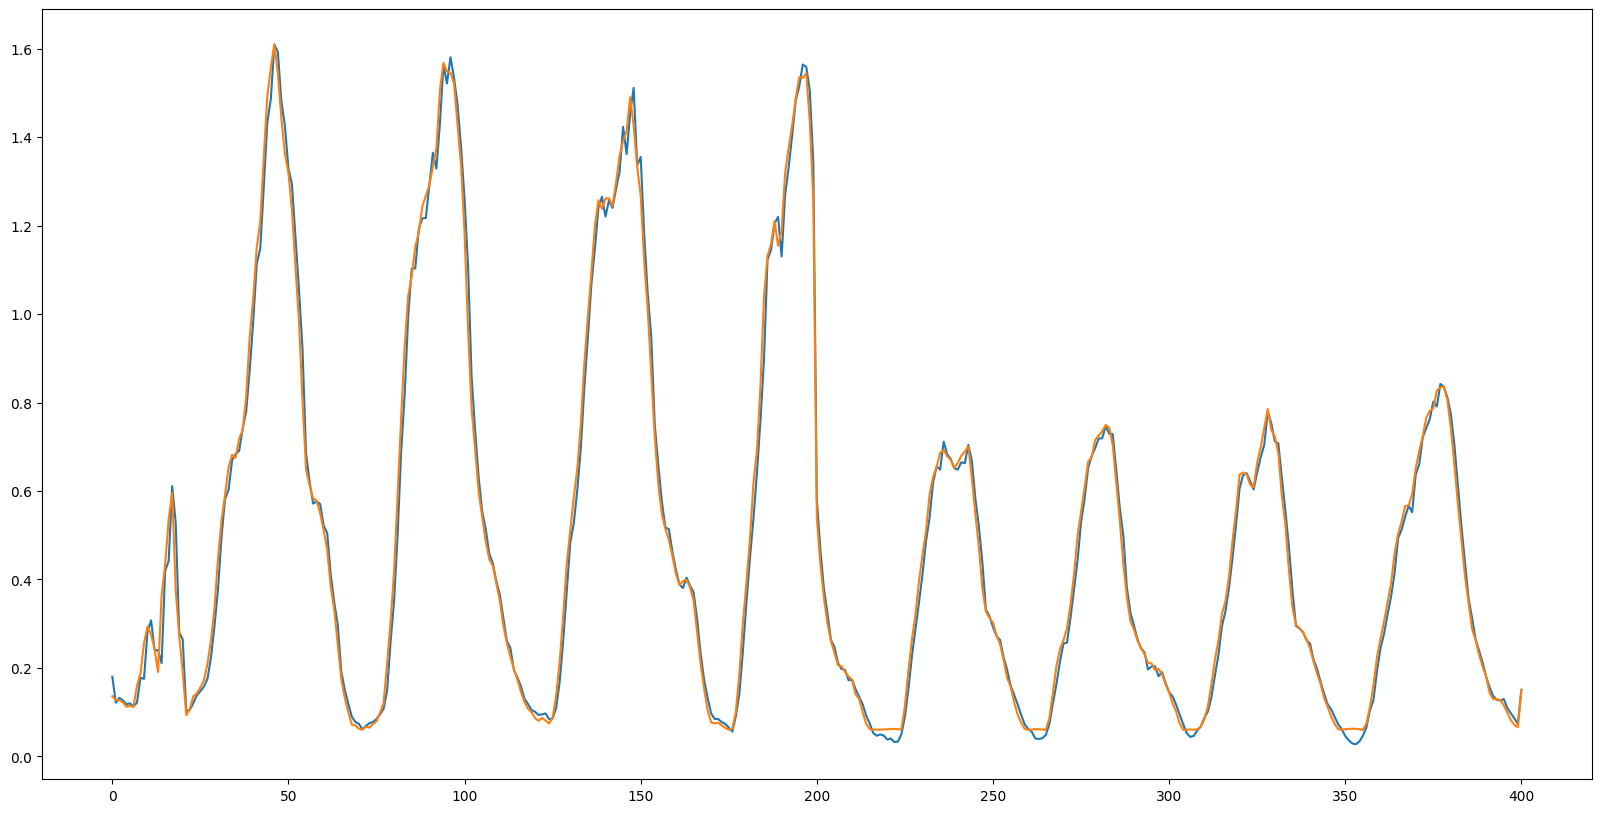

In [23]:
plt.figure(figsize=(20, 10))
plt.plot(gr, label='Ground truth')
plt.plot(pred, label='Predicted')
# plt.xlim(125, 225)

# plt.grid()
plt.show()